In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler, MinMaxScaler
pd.set_option('mode.use_inf_as_na', True)
pd.options.display.float_format = '{:,.2f}'.format

1 - Importação da base

In [20]:
df_indicadores = pd.read_excel('df_indicadores_3.xlsx',index_col=0)

# Dropa as 14 primeiras colunas, são as variáveis originais das peças contábeis
df_indicadores = df_indicadores.dropna(subset=df_indicadores.columns[:14]).reset_index(drop=True)
# Preenche os valores faltantes nas demais colunas com 0
df_indicadores.iloc[:, 10:] = df_indicadores.iloc[:, 10:].fillna(1)

indicadores = df_indicadores.drop(['DENOM_COMERC','CD_CVM','SETOR_ATIV'],axis=1)

empresas = pd.read_csv("cad_cia_aberta.csv",sep=';',encoding='latin-1')

<AxesSubplot:>

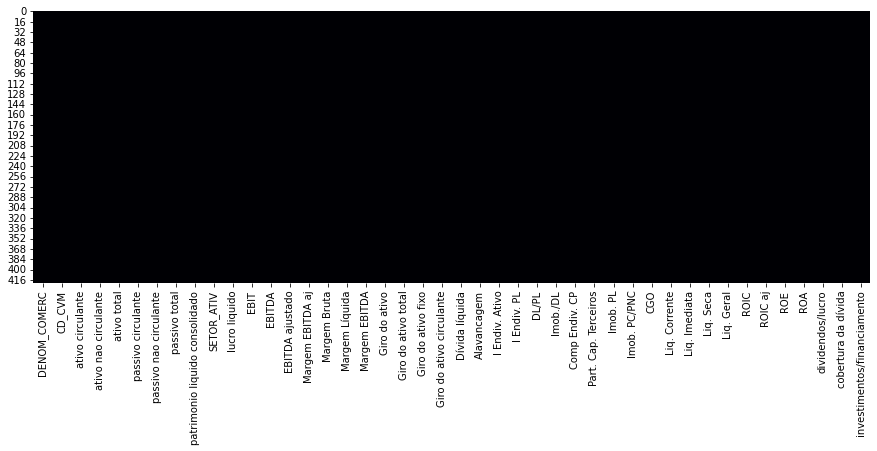

In [21]:
plt.figure(figsize=(15,5))
sns.heatmap(df_indicadores.isna(),cbar=False,cmap='magma')

In [22]:
# Remova 'Emp. Adm. Part. - ' de todas as entradas na coluna 'SETOR_ATIV'
empresas['SETOR_ATIV'] = empresas['SETOR_ATIV'].str.replace('Emp. Adm. Part. - ', '')

C:\Users\caiozas\AppData\Local\Temp\ipykernel_22316\2433470824.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  empresas['SETOR_ATIV'] = empresas['SETOR_ATIV'].str.replace('Emp. Adm. Part. - ', '')


In [23]:
indicadores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ativo circulante                421 non-null    float64
 1   ativo nao circulante            421 non-null    float64
 2   ativo total                     421 non-null    float64
 3   passivo circulante              421 non-null    float64
 4   passivo nao circulante          421 non-null    float64
 5   passivo total                   421 non-null    float64
 6   patrimonio liquido consolidado  421 non-null    float64
 7   lucro liquido                   421 non-null    float64
 8   EBIT                            421 non-null    float64
 9   EBITDA                          421 non-null    float64
 10  EBITDA ajustado                 421 non-null    float64
 11  Margem EBITDA aj                421 non-null    float64
 12  Margem Bruta                    421 

In [24]:
colunas_indices = ['Alavancagem','I Endiv. Ativo','I Endiv. PL','Part. Cap. Terceiros','Imob. PL','Imob. PC/PNC','Liq. Corrente','Liq. Imediata','Liq. Geral']
colunas_percentuais = ['ROIC','ROIC aj','ROE','ROA','Margem EBITDA aj','Margem EBITDA', 'Margem Bruta','Margem Líquida']

indicadores[colunas_percentuais + colunas_indices].describe().T[['mean','std','min','25%','75%','max']]

,mean,std,min,25%,75%,max
ROIC,0.15,1.05,-5.30,0.03,0.16,16.34
ROIC aj,0.35,8.27,-103.49,0.02,0.17,116.88
ROE,0.16,0.59,-3.67,0.02,0.20,7.88
ROA,-0.21,4.32,-87.44,-0.00,0.07,1.43
Margem EBITDA aj,0.22,0.77,-9.41,0.09,0.35,6.36
Margem EBITDA,0.19,0.73,-9.41,0.08,0.32,4.24
Margem Bruta,0.37,0.35,-4.55,0.22,0.49,1.06
Margem Líquida,-19.08,391.80,"-8,039.07",-0.01,0.14,9.35
Alavancagem,-1.30,137.85,"-2,557.71",0.15,3.62,"1,179.48"
I Endiv. Ativo,2.01,19.89,0.04,0.49,0.80,396.28


In [25]:
# Criando o Q-Q plot
#sm.qqplot(indicadores_filtro['Alavancagem'], line ='45')
#plt.title('Q-Q Plot para ' + 'Alavancagem')
#plt.xlabel('Quantis Teóricos')
#plt.ylabel('Quantis da Amostra')
#plt.show()

2 - Analise exploratória e tratamento da base

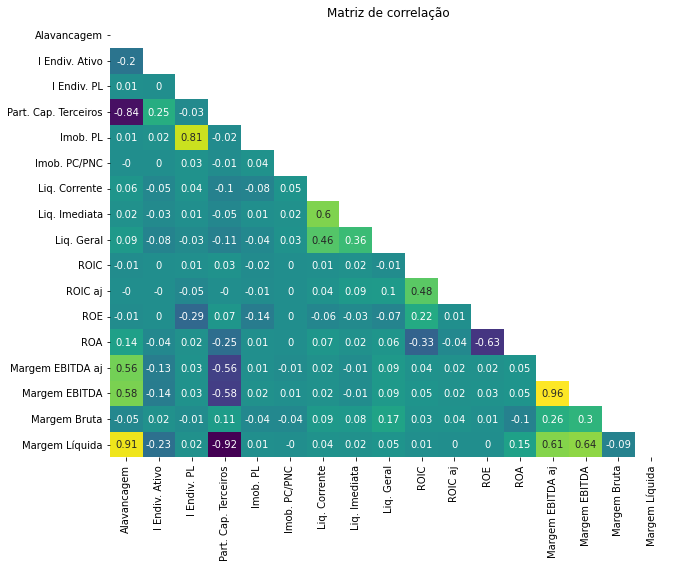

In [26]:
# Calculando a matriz de correlação
correlation_matrix = round(indicadores[colunas_indices+colunas_percentuais].corr(),2)

# máscara para esconder a parte triangular superior
mask = ~np.tri(*correlation_matrix.values.shape, k=-1, dtype=bool)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, cbar=False,cmap='viridis',annot=True)
plt.title('Matriz de correlação')
plt.show()

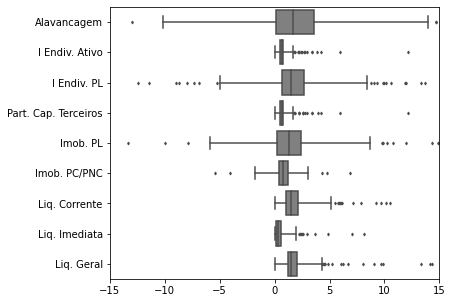

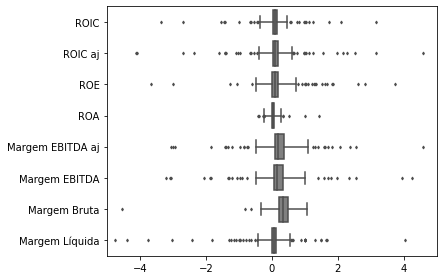

In [27]:
#não pode capital social negativo
indicadores_filtro = indicadores[indicadores['patrimonio liquido consolidado'] > 0]

# Configure o tamanho do gráfico
plt.figure(figsize=(13, 5))



# Cria o primeiro boxplot para as colunas índices
plt.subplot(1, 2, 1)  # Subplot de uma linha e dois colunas, primeiro boxplot
sns.boxplot(data=indicadores[colunas_indices], orient='h', whis=3, color='grey',fliersize=2,)
plt.ylabel('')
plt.xlim(-15, 15)

# Define o tamanho da figura
plt.figure(figsize=(11, 4))
# Cria o segundo boxplot para as colunas percentuais
plt.subplot(1, 2, 2)  # Subplot de uma linha e dois colunas, segundo boxplot
sns.boxplot(data=indicadores[colunas_percentuais], orient='h', whis=3, color='grey',fliersize=2)
plt.ylabel('')

# Remove os rótulos do eixo y para economizar espaço
plt.ylabel('')
plt.xlim(-5, 5)
# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Mostra os boxplots
plt.show()

In [28]:
#função para filtro de outlier com base em IQR
def filtro_outliers(data, coluna, fator_limite):
    # Calculo dos quartis e do IQR
    Q1 = data[coluna].quantile(0.25)
    Q3 = data[coluna].quantile(0.75)
    IQR = Q3 - Q1
    
    # Defina os limites inferior e superior
    lim_inf = Q1 - fator_limite * IQR
    lim_sup = Q3 + fator_limite * IQR
    
    # filtro da base
    data_filtrado = data[(data[coluna] > lim_inf) & (data[coluna] < lim_sup)]
    
    return data_filtrado

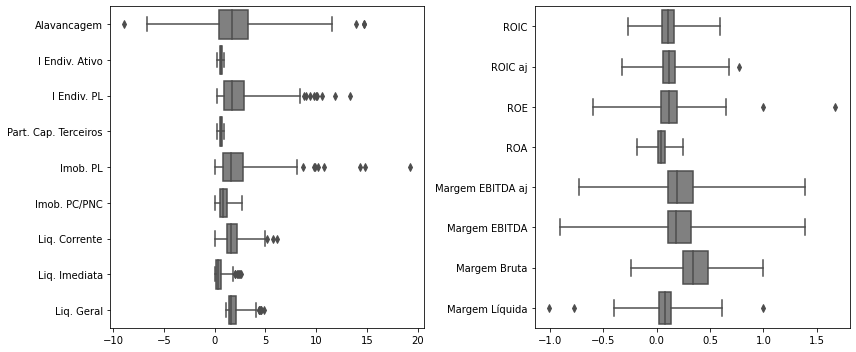

In [29]:
#não pode capital social negativo
indicadores_filtro = indicadores[indicadores['patrimonio liquido consolidado'] > 0]

colunas_selecionadas = ['Liq. Corrente', 'Liq. Geral','Alavancagem','Margem EBITDA aj']
fator_limite = 4

#filtro de outliers primeira leva
for coluna in colunas_selecionadas:
    indicadores_filtro = filtro_outliers(indicadores_filtro, coluna, fator_limite)
    
colunas_selecionadas = ['I Endiv. Ativo','I Endiv. PL','ROIC aj','ROIC']
fator_limite = 5

#filtro de outliers segunda leva
for coluna in colunas_selecionadas:
    indicadores_filtro = filtro_outliers(indicadores_filtro, coluna, fator_limite)


# Define o tamanho da figura
plt.figure(figsize=(12, 5))

# Cria o primeiro boxplot para as colunas índices
plt.subplot(1, 2, 1)  # Subplot de uma linha e dois colunas, primeiro boxplot
sns.boxplot(data=indicadores_filtro[colunas_indices], orient='h', whis=3, color='gray')
plt.ylabel('')

# Cria o segundo boxplot para as colunas percentuais
plt.subplot(1, 2, 2)  # Subplot de uma linha e dois colunas, segundo boxplot
sns.boxplot(data=indicadores_filtro[colunas_percentuais], orient='h', whis=5, color='gray')
plt.ylabel('')

# Remove os rótulos do eixo y para economizar espaço
plt.ylabel('')

# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Mostra os boxplots
plt.show()


In [30]:
# Calcular a razão entre o desvio padrão e a média para as últimas 20 colunas do DataFrame original
razao_indicadores = indicadores[indicadores.columns[-20:]].std() / indicadores[indicadores.columns[-20:]].mean()

# Calcular a razão entre o desvio padrão e a média para as últimas 20 colunas do DataFrame filtrado
razao_indicadores_filtro = indicadores_filtro[indicadores_filtro.columns[-20:]].std() / indicadores_filtro[indicadores_filtro.columns[-20:]].mean()

# Criar um DataFrame para armazenar os resultados
df_resultados = pd.DataFrame({
    'STD/MEAN': razao_indicadores.index,
    'Original': razao_indicadores.values,
    'Filtrado': razao_indicadores_filtro.values
})

print('Tamanho da base final: ',len(indicadores_filtro))
df_resultados

Tamanho da base final:  316


,STD/MEAN,Original,Filtrado
0,I Endiv. Ativo,9.92,0.28
1,I Endiv. PL,4.67,0.90
2,DL/PL,8.02,1.35
3,Imob./DL,37.71,55.32
4,Comp Endiv. CP,0.49,0.45
5,Part. Cap. Terceiros,4.69,0.27
6,Imob. PL,4.01,1.07
7,Imob. PC/PNC,119.33,0.62
8,CGO,2.86,2.37
9,Liq. Corrente,0.75,0.51


In [31]:
chi_square_value, p_value = calculate_bartlett_sphericity(indicadores_filtro)
print("Teste de Esfericidade de Bartlett:")
print("Chi-Square Value:", chi_square_value)
print("P-value:", round(p_value,2))
# Teste KMO
kmo_all, kmo_model = calculate_kmo(indicadores_filtro)
print("\nTeste Kaiser-Meyer-Olkin (KMO):")
print("KMO global:", kmo_model)

Teste de Esfericidade de Bartlett:
Chi-Square Value: nan
P-value: nan

Teste Kaiser-Meyer-Olkin (KMO):
KMO global: 6.891305450913272e-08


C:\Users\caiozas\Anaconda39\lib\site-packages\factor_analyzer\factor_analyzer.py:108: RuntimeWarning: invalid value encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)


In [32]:
fa = FactorAnalyzer(10)
fa.fit(indicadores)
# cargas fatoriais e os erros específicos
factor_loadings = fa.loadings_
specific_variances = fa.get_uniquenesses()

# MSA para cada variável
msa_per_variable = (factor_loadings**2).sum(axis=1) / ((factor_loadings**2).sum(axis=1) + specific_variances)
msa_df = pd.DataFrame({'Variavel': indicadores_filtro.columns, 'MSA': msa_per_variable})
print(msa_df.sort_values('MSA'))

indicadores_filtro_2 = indicadores_filtro.drop(msa_df[msa_df['MSA'] < 0.44]['Variavel'],axis=1)

                          Variavel  MSA
38                dividendos/lucro 0.01
40     investimentos/financiamento 0.01
28                    Imob. PC/PNC 0.07
18        Giro do ativo circulante 0.12
34                            ROIC 0.23
17              Giro do ativo fixo 0.30
12                    Margem Bruta 0.31
29                             CGO 0.41
31                   Liq. Imediata 0.44
33                      Liq. Geral 0.45
36                             ROE 0.53
25                  Comp Endiv. CP 0.64
39             cobertura da dívida 0.70
27                        Imob. PL 0.75
11                Margem EBITDA aj 0.77
19                  Dívida líquida 0.77
3               passivo circulante 0.80
20                     Alavancagem 0.81
0                 ativo circulante 0.81
14                   Margem EBITDA 0.86
37                             ROA 0.88
22                     I Endiv. PL 0.89
26            Part. Cap. Terceiros 0.92
7                    lucro liquido 0.93


In [33]:
chi_square_value, p_value = calculate_bartlett_sphericity(indicadores_filtro_2)
print("Teste de Esfericidade de Bartlett:")
print("Chi-Square Value:", chi_square_value)
print("P-value:", round(p_value,2))
#Teste KMO
kmo_all, kmo_model = calculate_kmo(indicadores_filtro_2)
print("\nTeste Kaiser-Meyer-Olkin (KMO):")
print("KMO global:", kmo_model)

Teste de Esfericidade de Bartlett:
Chi-Square Value: 47357.84085885605
P-value: 0.0

Teste Kaiser-Meyer-Olkin (KMO):
KMO global: 0.28543130541778766


C:\Users\caiozas\Anaconda39\lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


3 - Analise fatorial

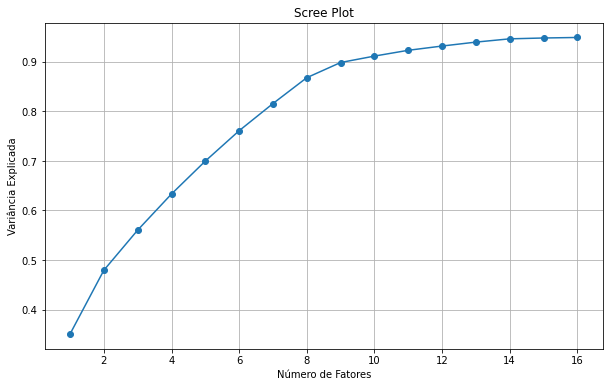

In [34]:
rotation_met = 'varimax'

z_indicadores_2 = StandardScaler().fit_transform(indicadores_filtro_2)


n_factor = int(len(indicadores_filtro_2.columns)/2)
fa = FactorAnalyzer(n_factor,rotation=rotation_met)

# Ajustar o modelo aos dados
fa.fit(z_indicadores_2)

# Calcular os loadings (cargas fatoriais)
loadings = fa.loadings_
# Calcular a variância explicada
variance = fa.get_factor_variance()

plt.figure(figsize=(10, 6))
#plt.scatter(range(1, fa.n_factors+1), variance[2], color='red')
plt.plot(range(1, fa.n_factors+1), variance[2], marker='o')
plt.title('Scree Plot')
plt.xlabel('Número de Fatores')
plt.ylabel('Variância Explicada')
plt.grid()
plt.show()

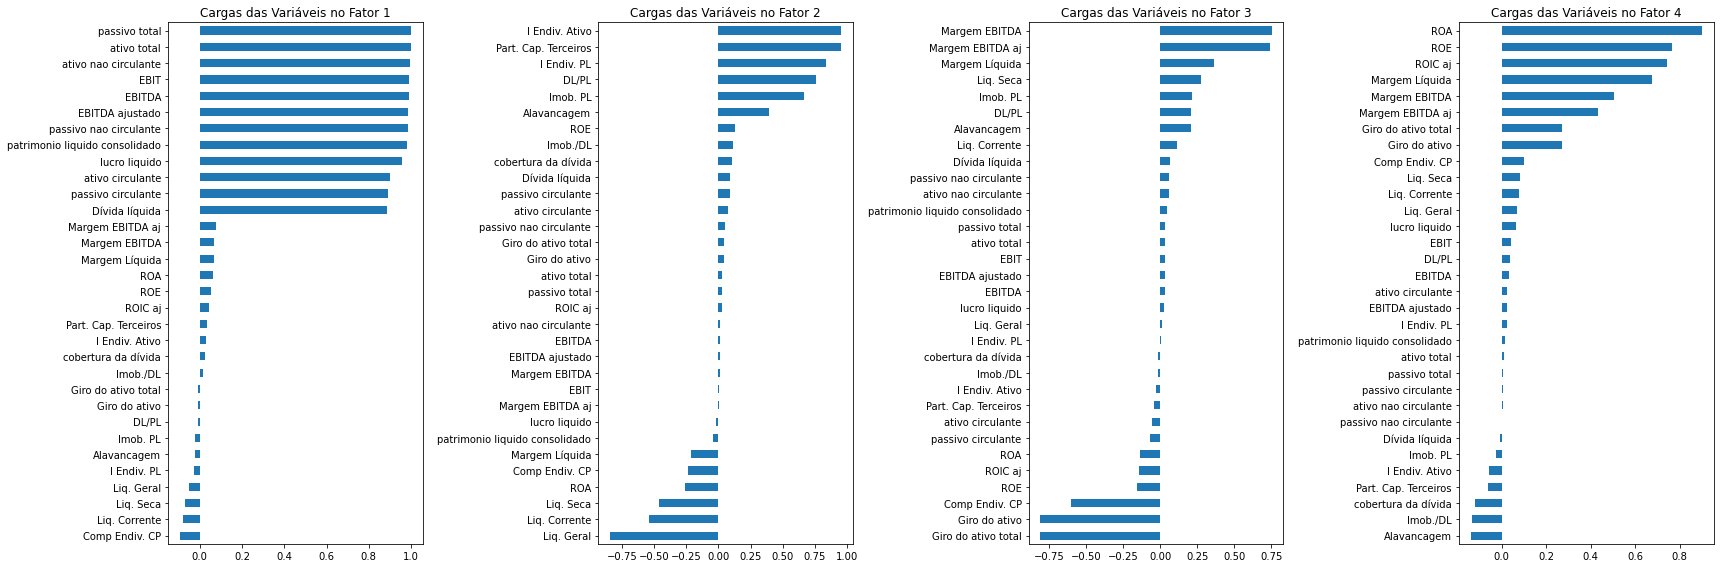

In [35]:
fa = FactorAnalyzer(4,rotation=rotation_met)

# Ajustar o modelo aos dados
fa.fit(z_indicadores_2)

# Calcular os loadings (cargas fatoriais)
loadings = fa.loadings_

# DataFrame para armazenar os loadings e as variáveis correspondentes
loadings_df = pd.DataFrame(loadings, columns=[f'Fator {i+1}' for i in range(loadings.shape[1])], index=indicadores_filtro_2.columns)

# gráficos de barras lado a lado para cada fator (componente)
fig, axs = plt.subplots(1, loadings.shape[1], figsize=(fa.n_factors*6, len(indicadores_filtro_2.columns)/4))  # 1 linha, número de colunas igual ao número de fatores

for i, ax in enumerate(axs):
    loadings_df[f'Fator {i+1}'].sort_values().plot(kind='barh', ax=ax)
    ax.set_title(f'Cargas das Variáveis no Fator {i+1}')

plt.tight_layout()
plt.show()

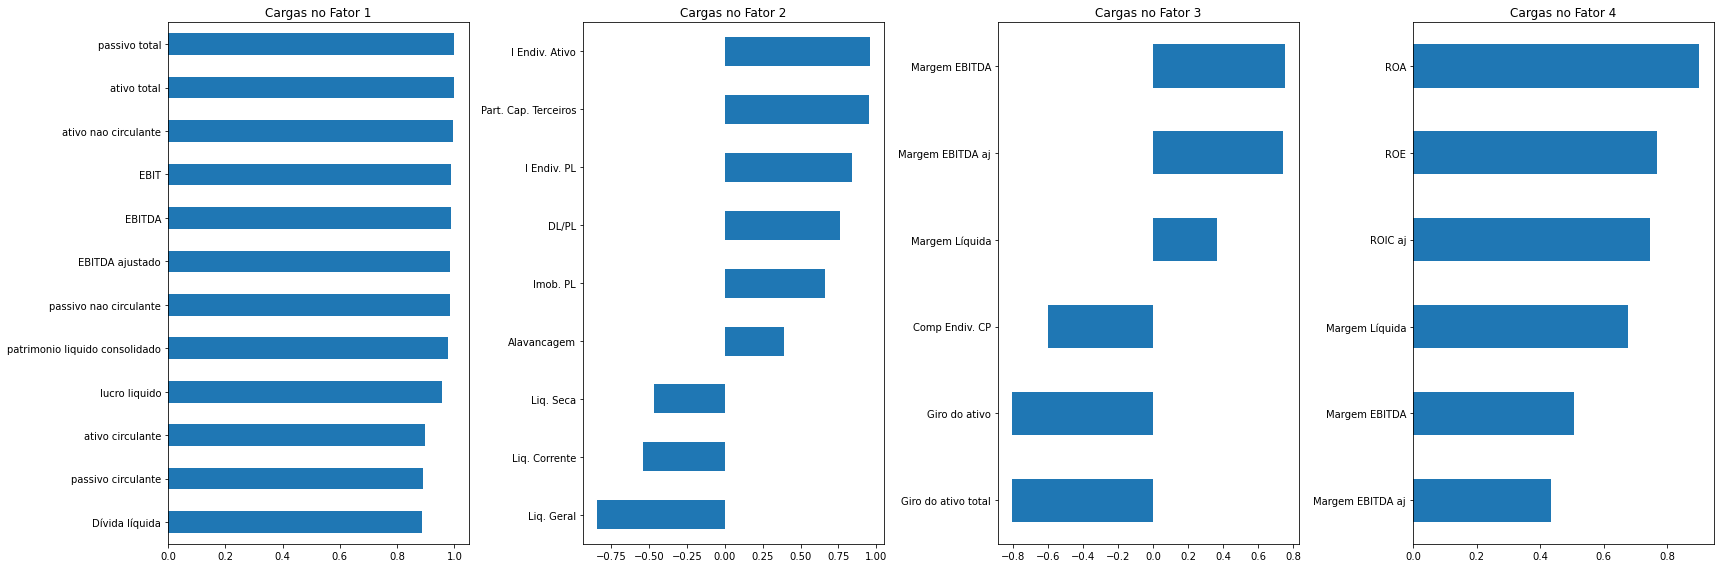

In [36]:
# Aplicar o filtro nas cargas fatoriais
filtered_loadings_df = loadings_df.applymap(lambda x: np.nan if abs(x) < 0.3 else x)

# Gráficos de barras lado a lado para cada fator (componente) com as cargas filtradas
fig, axs = plt.subplots(1, loadings.shape[1], figsize=(fa.n_factors*6, len(indicadores_filtro_2.columns)/4))  # 1 linha, número de colunas igual ao número de fatores

for i, ax in enumerate(axs):
    # Filtrar as cargas fatoriais para o fator atual (maiores que 0.3 em valor absoluto)
    filtered_loadings = filtered_loadings_df[f'Fator {i+1}'].dropna()
    
    # Plotar as barras apenas para as variáveis filtradas
    filtered_loadings.sort_values().plot(kind='barh', ax=ax)
    
    ax.set_title(f'Cargas no Fator {i+1}')
    #ax.set_xlabel('Carga')
    #ax.set_ylabel('Variáveis')

plt.tight_layout()
plt.show()

<AxesSubplot:>

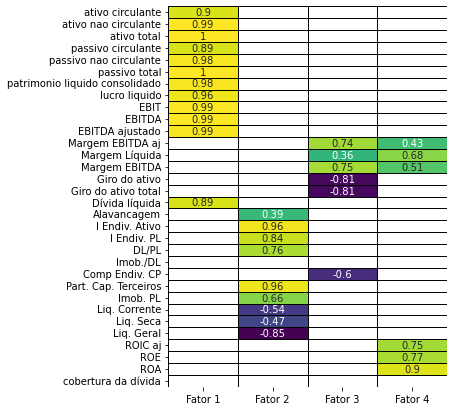

In [37]:
plt.figure(figsize=(5, 7))
cargas_on = loadings_df[np.abs(loadings_df) > 0.3]
sns.heatmap(cargas_on,cmap='viridis',cbar=False,annot=True,linewidths=1,linecolor='black')

<AxesSubplot:>

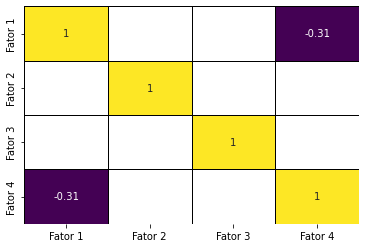

In [38]:
corr_matrix = loadings_df.corr()[np.abs(loadings_df.corr()) > 0.3]
#mask = ~np.tri(*corr_matrix.values.shape, k=-1, dtype=bool)

sns.heatmap(corr_matrix, cbar=False,cmap='viridis',annot=True,linewidths=1,linecolor='black')

<AxesSubplot:>

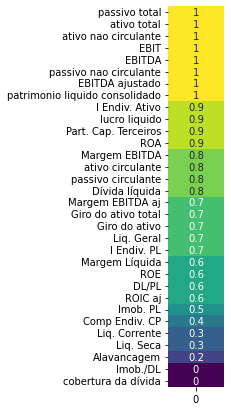

In [39]:
plt.figure(figsize=(1, 7))

comunalidades = fa.get_communalities()
comunalidade_df = pd.DataFrame(comunalidades, index=indicadores_filtro_2.columns).sort_values(0,ascending=False)
sns.heatmap(round(comunalidade_df,1),cmap='viridis',cbar=False,annot=True)

4 - Classificação dos individuos

In [40]:
df_indicadores_fatores = df_indicadores.iloc[indicadores_filtro_2.index][['DENOM_COMERC','CD_CVM','SETOR_ATIV']]

f_names = ['Dimensão','Rentabilidade','Estrutura','Performance']

for i,f in enumerate(cargas_on.to_numpy().T):
    df_indicadores_fatores[f_names[i]] = (f * indicadores_filtro_2).T.mean()
    
#scaling the factores    
df_indicadores_fatores['Estrutura'] = -df_indicadores_fatores['Estrutura']
df_indicadores_fatores[f_names] = MinMaxScaler().fit_transform(df_indicadores_fatores[f_names])


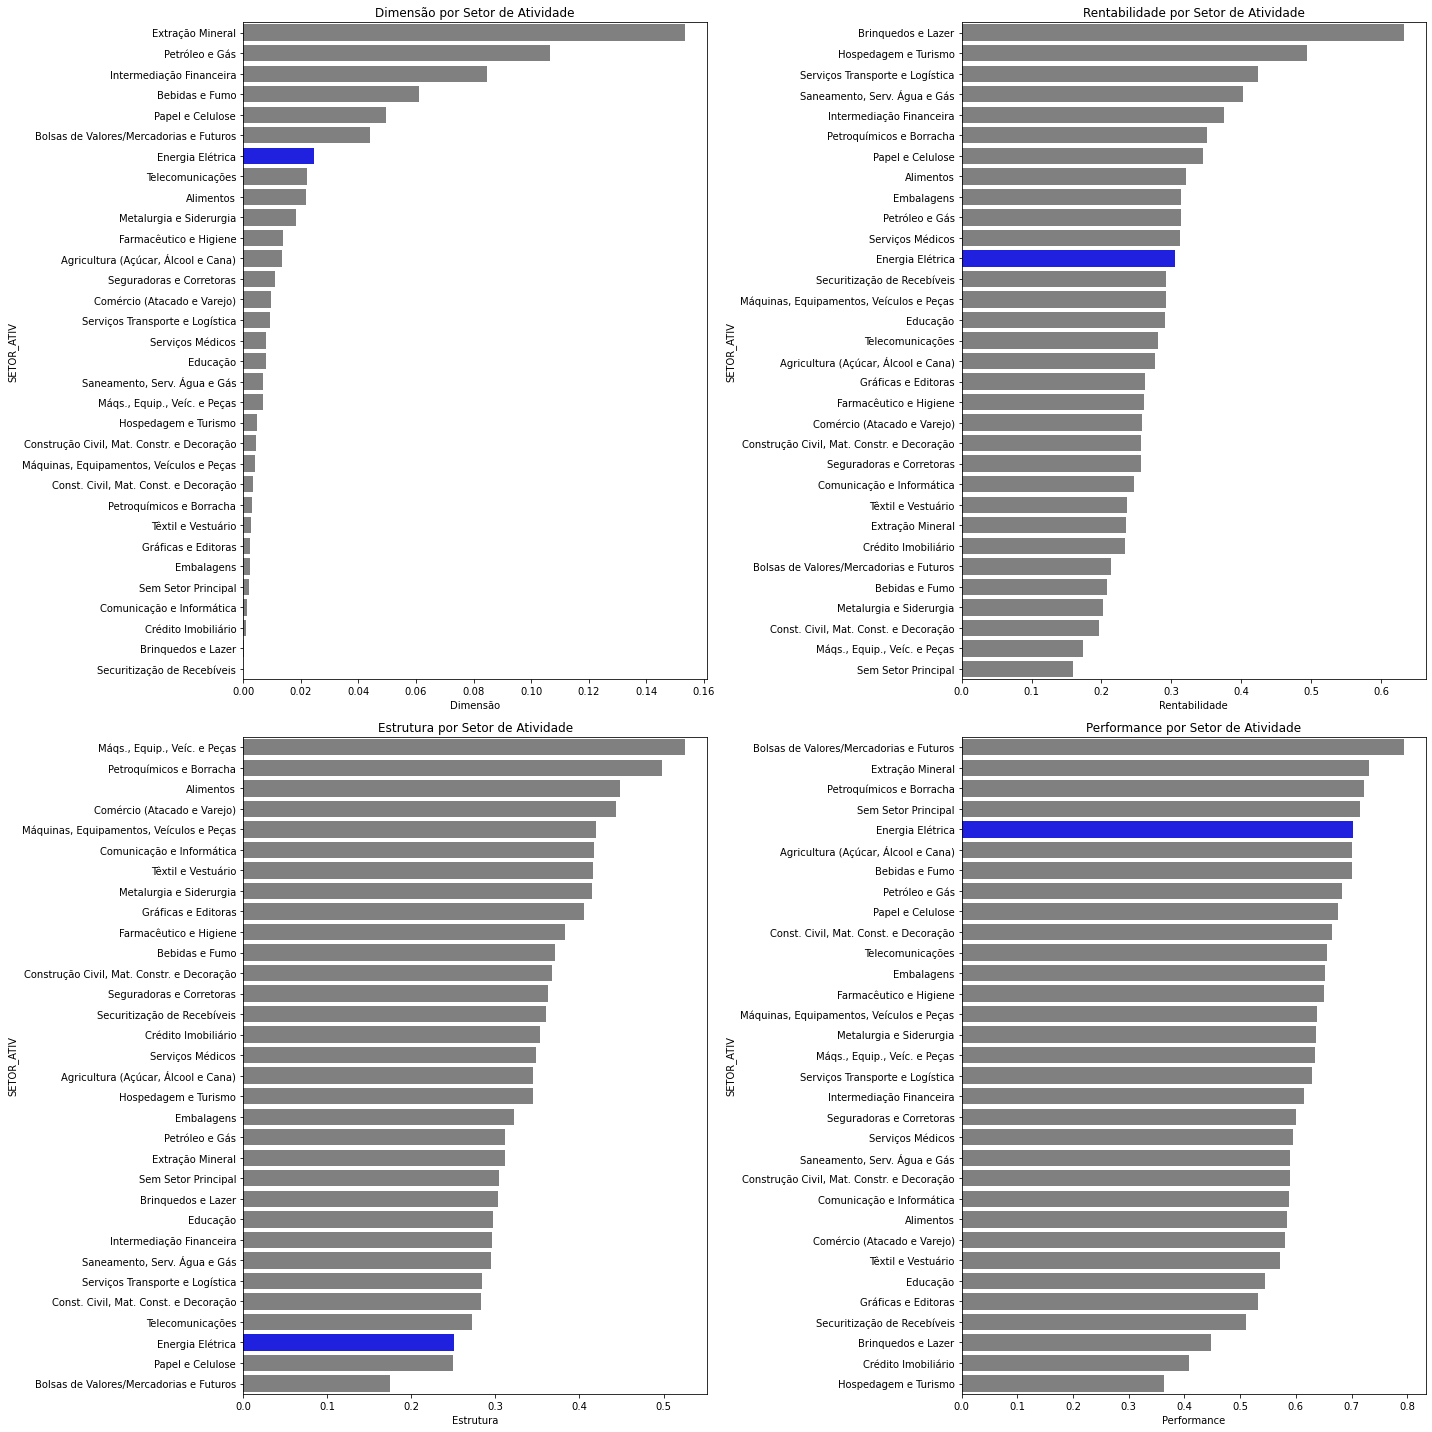

In [41]:

fig, axs = plt.subplots(2, 2, figsize=(20, 20))
# Loop sobre cada KPI
for i, KPI in enumerate(f_names):
    row = i // 2  # Calcula a linha do subplot
    col = i % 2   # Calcula a coluna do subplot
    
    
    # Remova outliers
    # Defina um fator de escala (por exemplo, 1.5)
    scale_factor = 3000
    df_indicadores_filtered = filtro_outliers(df_indicadores_fatores,KPI,scale_factor)

    
    # Ordena os setores por desempenho para cada KPI
    data = df_indicadores_filtered.groupby('SETOR_ATIV').mean().reset_index().sort_values(KPI, ascending=False)

    # Usa uma paleta de cores mais intuitiva
    colors = ['blue' if setor == 'Energia Elétrica' else 'gray' for setor in data['SETOR_ATIV']]

    # Cria o gráfico de barras
    bar_plot = sns.barplot(ax=axs[row, col],data=data, y='SETOR_ATIV', x=KPI, palette=colors)
    
    # Define o limite no eixo x
    #plt.xlim(0, data[KPI].max() * 1.2)

    # Adiciona título ao gráfico
    bar_plot.set_title(f'{KPI} por Setor de Atividade')

# Ajusta o layout
plt.tight_layout()

# Mostra os gráficos
plt.show()

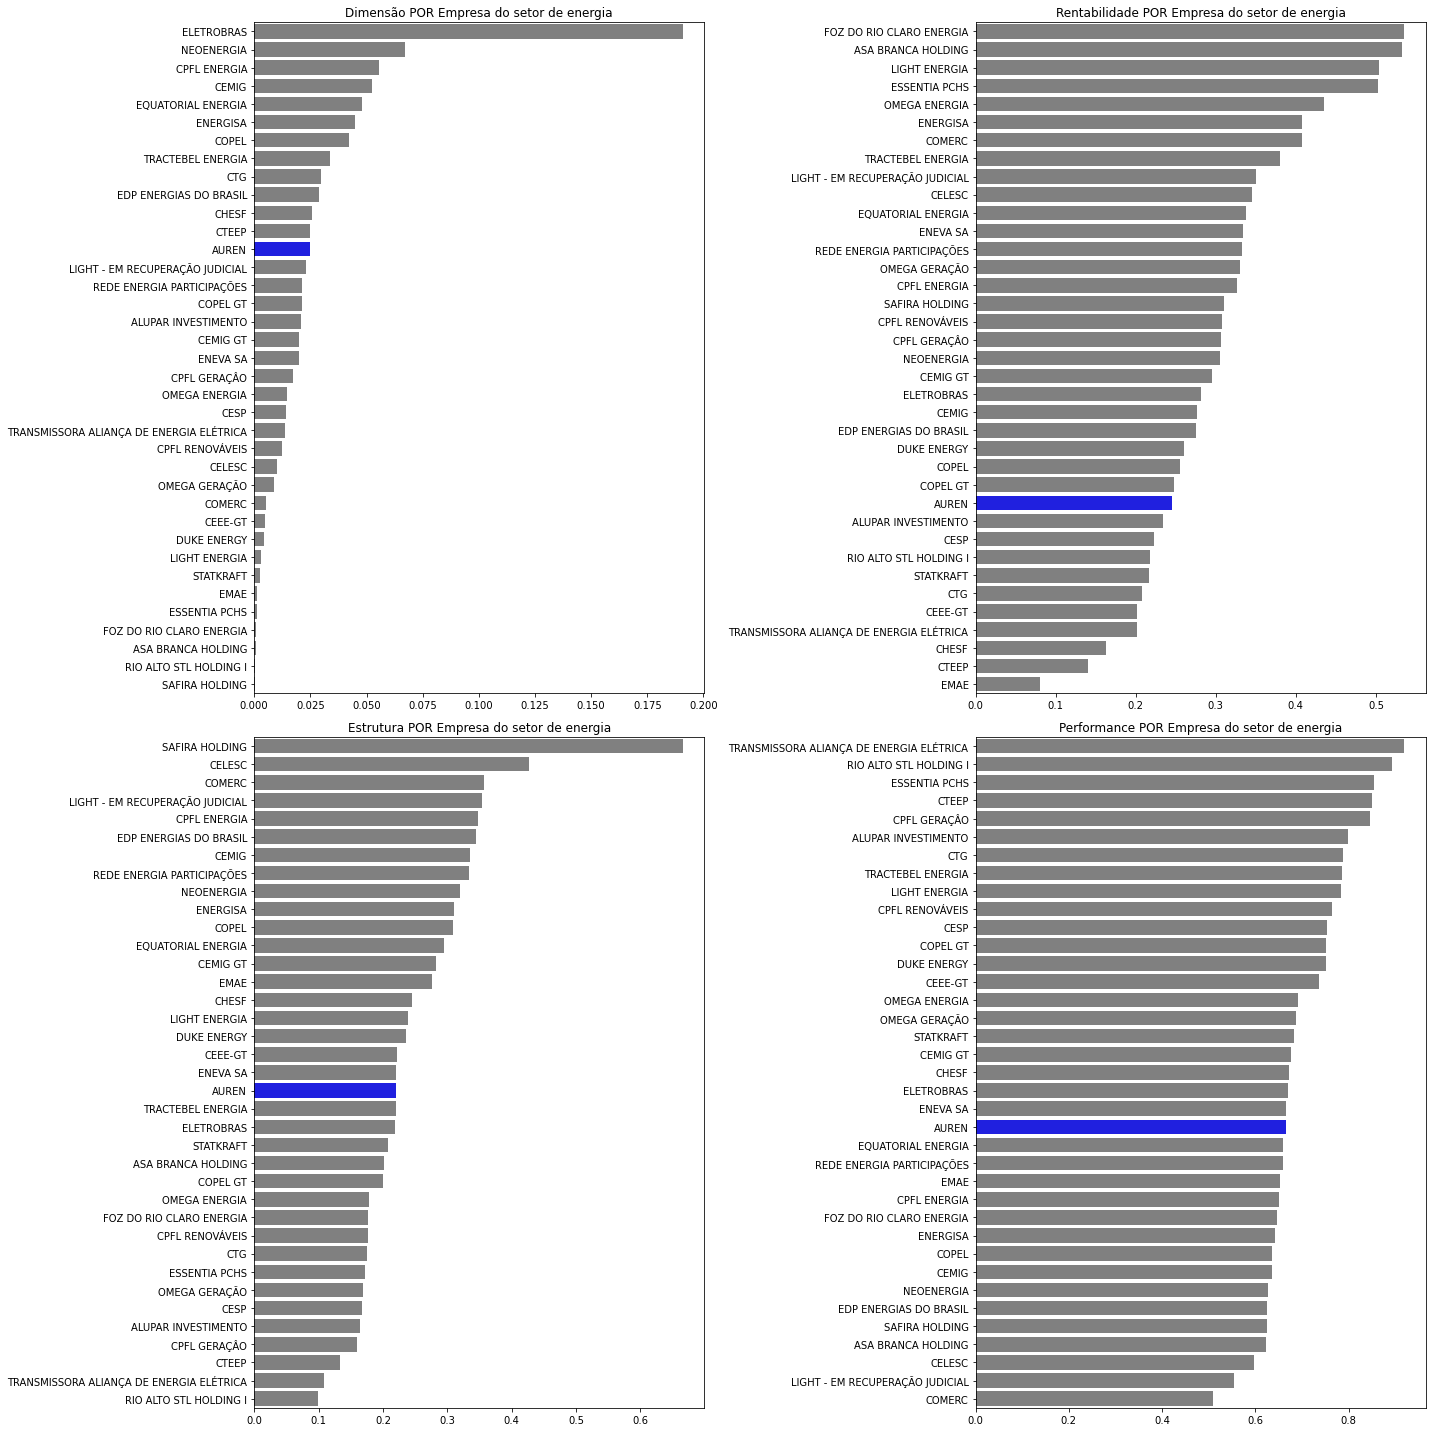

In [42]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Loop sobre cada KPI
for i, KPI in enumerate(f_names):
    row = i // 2  # Calcula a linha do subplot
    col = i % 2   # Calcula a coluna do subplot
    
    # Remova outliers
    # Defina um fator de escala (por exemplo, 1.5)
    scale_factor = 3000
    df_indicadores_filtered = filtro_outliers(df_indicadores_fatores,KPI,scale_factor)

    setor_eletrico = df_indicadores_filtered[(df_indicadores_filtered['SETOR_ATIV'] == "Energia Elétrica")]
    
    # Ordena os setores por desempenho para cada KPI
    data = setor_eletrico.sort_values(KPI, ascending=False)

    colors = ['blue' if setor == 'AUREN' else 'gray' for setor in data['DENOM_COMERC']]
    bar_plot = sns.barplot(ax=axs[row, col], data=data, y='DENOM_COMERC', x=KPI, palette=colors)
    #bar_plot.set_xlim(0, data[KPI].max() * 1.2)
    bar_plot.set_title(f'{KPI} POR Empresa do setor de energia')
    # Remova os títulos dos eixos x e y
    bar_plot.set_xlabel('')
    bar_plot.set_ylabel('')
    
# Ajusta o layout
plt.tight_layout()

# Mostra os gráficos
plt.show()

In [58]:
loadings_df.columns = f_names

fator = 'Dimensão'
variaveis = list(loadings_df[abs(loadings_df[fator]) > .3].index)
df_fator_selecionado = setor_eletrico[['DENOM_COMERC','CD_CVM',fator]]
df_indicadores_selecionados = df_indicadores[(df_indicadores['CD_CVM'].isin(setor_eletrico['CD_CVM'].unique()))][['DENOM_COMERC','CD_CVM'] + variaveis]
df_fator_selecionado = df_fator_selecionado.merge(df_indicadores_selecionados,on=['DENOM_COMERC','CD_CVM'],how='left').sort_values(fator,ascending=False)

df_fator_selecionado

,DENOM_COMERC,CD_CVM,Dimensão,ativo total,ativo circulante,ativo nao circulante,passivo total,passivo circulante,passivo nao circulante,Dívida líquida,patrimonio liquido consolidado,lucro liquido,EBIT,EBITDA,EBITDA ajustado
0,ELETROBRAS,2437,0.20,"195,049,171.67","43,375,207.67","151,673,964.00","195,049,171.67","28,962,734.67","95,172,004.75","45,999,946.00","71,852,906.50","6,415,772.33","10,503,367.67","10,818,075.00","10,075,593.08"
9,NEOENERGIA,15539,0.07,"64,556,707.83","15,630,032.33","48,926,675.50","64,556,707.83","13,312,881.83","30,389,134.50","23,550,370.17","20,854,691.50","2,685,413.33","5,292,611.83","6,314,847.33","6,225,582.83"
14,CPFL ENERGIA,18660,0.06,"52,324,263.00","12,311,417.00","40,012,846.00","52,324,263.00","12,009,761.33","26,050,574.17","18,196,737.33","15,466,209.50","3,322,814.00","5,806,933.33","7,112,834.83","7,354,242.83"
1,CEMIG,2453,0.05,"52,069,951.83","14,759,442.67","37,310,509.17","52,069,951.83","11,933,904.17","21,852,658.20","12,417,748.50","17,515,724.50","2,775,003.17","4,282,126.17","5,069,869.67","5,673,249.67"
18,EQUATORIAL ENERGIA,20010,0.05,"46,163,376.67","15,075,773.00","31,768,806.83","48,831,536.25","10,078,397.17","24,830,931.83","16,767,519.33","11,254,047.67","2,458,990.00","3,807,219.33","4,700,691.25","4,827,609.92"
8,ENERGISA,15253,0.05,"42,879,608.83","12,064,507.83","30,815,101.00","42,879,608.83","9,849,197.00","25,300,536.67","18,034,364.33","7,729,875.17","1,521,618.83","3,250,934.33","5,512,930.08","5,427,079.92"
7,COPEL,14311,0.04,"42,238,487.67","8,702,238.00","33,536,249.67","42,238,487.67","7,156,938.50","16,247,898.00","8,648,337.33","18,833,651.17","2,455,466.83","3,408,875.83","4,159,757.83","4,615,912.83"
11,TRACTEBEL ENERGIA,17329,0.03,"30,821,393.50","6,444,647.67","24,376,745.83","30,821,393.50","5,478,780.00","17,964,465.33","10,891,362.83","7,378,148.17","2,276,311.83","4,513,415.00","5,366,690.67","6,491,322.67"
34,CTG,27103,0.03,"29,400,901.50","4,014,548.00","25,386,353.50","29,400,901.50","4,769,470.00","8,424,637.00","2,414,994.00","16,206,794.50","2,012,145.00","3,599,183.50","4,193,997.50","4,235,959.00"
16,EDP ENERGIAS DO BRASIL,19763,0.03,"28,590,047.00","7,906,878.50","20,683,168.50","28,590,047.00","6,504,728.83","11,337,015.00","6,596,075.17","10,748,303.17","1,479,955.83","2,693,888.00","3,357,951.83","3,537,814.83"


In [55]:
df_fator_selecionado['DENOM_COMERC'][36]

'CIA ESTADUAL DE GERAÇÃO DE ENERGIA ELÉTRICA - CEEE-G'

In [41]:
#df_indicadores_fatores.to_excel('df_fatores.xlsx')

In [43]:
#indicadores_filtro_2.to_excel('df_indicadores_filtro.xlsx')